# Aula 13 - Multi-Armed Bandits - MovieLens

In [ ]:
%%sh
wget -q http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip -q ml-100k.zip
rm ml-100k.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Carregamento do dataset MovieLens
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Converte os IDs para começar em zero

ratings['user_id'] = ratings['user_id'] - 1
ratings['movie_id'] = ratings['movie_id'] - 1
# Filtragem e criação de coluna de feedback positivo (rating >= 3)
ratings['positive_feedback'] = ratings['rating'] >= 3

# Divisão em conjunto de treino e teste (80% treino, 20% teste)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Mapeamento dos IDs de filmes e usuários para índices contínuos
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(ratings['movie_id'].unique())}
user_id_map = {user_id: idx for idx, user_id in enumerate(ratings['user_id'].unique())}

# Substituir os IDs de filme e usuário pelos índices mapeados
train_ratings['movie_idx'] = train_ratings['movie_id'].map(movie_id_map)
train_ratings['user_idx'] = train_ratings['user_id'].map(user_id_map)
test_ratings['movie_idx'] = test_ratings['movie_id'].map(movie_id_map)
test_ratings['user_idx'] = test_ratings['user_id'].map(user_id_map)

# Carregar a tabela de filmes do MovieLens, que contém os gêneros dos filmes
movies_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
               'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
               'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
               'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies['movie_id'] = movies['movie_id'] - 1
# Selecionamos apenas as colunas de gênero (binárias) do dataframe
movie_genres = movies.set_index('movie_id')[movies_cols[5:]].copy()  # As colunas de gêneros começam na posição 5

# Atualizar movie_genres para usar os índices contínuos (movie_idx)
movie_genres.index = movie_genres.index.map(movie_id_map)

# Agora vamos carregar as informações dos usuários
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')
users['user_id'] = users['user_id'] - 1


In [ ]:
# Algoritmo UCB1 com ajuste para explorar filmes populares inicialmente
class UCB1Recommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme

    def select_arm(self):
        # Algoritmo UCB1
        total_counts = np.sum(self.counts)
        if total_counts == 0:
            return np.random.randint(0, self.n_arms)  # Se nenhum filme foi selecionado ainda, escolha aleatoriamente

        ucb_values = self.values + np.sqrt(2 * np.log(total_counts) / (self.counts + 1e-5))  # Evitar divisão por zero
        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [ ]:
# Algoritmo Epsilon-Greedy
class EpsilonGreedyRecommender:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon  # Probabilidade de exploração
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme

    def select_arm(self):
        # Com probabilidade epsilon, fazemos uma escolha aleatória (exploração)
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        # Caso contrário, fazemos explotação
        return np.argmax(self.values)

    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [ ]:
# Algoritmo Thompson Sampling
class ThompsonSamplingRecommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)  # Número de sucessos (recompensa 1)
        self.failures = np.zeros(n_arms)  # Número de falhas (recompensa 0)

    def select_arm(self):
        # Amostra da distribuição Beta para cada braço e escolhe o que tem a maior amostra
        beta_samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.n_arms)]
        return np.argmax(beta_samples)

    def update(self, chosen_arm, reward):
        # Atualiza os parâmetros da distribuição Beta com base na recompensa
        if reward == 1:
            self.successes[chosen_arm] += 1
        else:
            self.failures[chosen_arm] += 1

In [ ]:
# Algoritmo LinUCB personalizado para cada usuário usando gêneros como contexto
class LinUCBRecommender:
    def __init__(self, n_features, n_arms, alpha=1.5):
        self.alpha = alpha  # Parâmetro de confiança
        self.n_arms = n_arms

        # Para cada arm, teremos uma matriz A e um vetor b
        self.A = [np.identity(n_features) for _ in range(n_arms)]  # Matriz A para cada arm
        self.b = [np.zeros(n_features) for _ in range(n_arms)]  # Vetor b para cada arm

    def select_arm(self, contexts):
        # Calcular p(a) para cada contexto
        p = np.zeros(self.n_arms)

        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])  # Inversa de A para cada arm
            theta = np.dot(A_inv, self.b[arm])  # Estimativa de theta para cada arm
            context = contexts[arm]

            # p(a) = theta^T * x + alpha * sqrt(x^T * A^-1 * x)
            p[arm] = np.dot(theta, context) + self.alpha * np.sqrt(np.dot(context.T, np.dot(A_inv, context)))

        return np.argmax(p)  # Seleciona o braço com a maior estimativa de recompensa


    def update(self, chosen_arm, contexts, reward):
        # Atualizar as estimativas A e b com base no braço escolhido
        chosen_context = contexts[chosen_arm]  # Obter o contexto do braço escolhido

        # Atualização da matriz A e vetor b para o braço escolhido
        self.A[chosen_arm] += np.outer(chosen_context, chosen_context)  # Atualiza A para o braço escolhido
        self.b[chosen_arm] += reward * chosen_context  # Atualiza b para o braço escolhido

In [ ]:
# Função para simular o processo de recomendação para todos os usuários usando os dados de treino
def train_recommender(recommender, train_ratings):
    # Agrupar os ratings pelo ID do usuário para evitar filtragens repetidas
    for user_idx, user_ratings in tqdm(train_ratings.groupby('user_idx'), desc="Training", unit="user"):

        movie_indices = user_ratings['movie_idx'].values
        positive_feedback = user_ratings['positive_feedback'].values

        for i, movie_idx in enumerate(movie_indices):
            reward = 1 if positive_feedback[i] else 0  # Pega diretamente o feedback
            if isinstance(recommender, LinUCBRecommender):
                context = get_context(user_idx, movie_idx)  # Obter o contexto combinado usando índices
                recommender.update(0, [context], reward)
            else:
                recommender.update(movie_idx, reward)

# Função para testar o recomendador e calcular o ganho acumulado
def test_recommender(recommender, test_ratings, n_rounds_per_user, available_movies):
    cumulative_rewards = np.zeros(n_rounds_per_user)
    num_users = test_ratings['user_idx'].nunique()  # Número de usuários únicos

    # Verificar o tipo do recomendador uma única vez antes do loop
    is_linucb = isinstance(recommender, LinUCBRecommender)

    # Agrupar os ratings por usuário para evitar filtragem repetida
    for user_idx, user_ratings in tqdm(test_ratings.groupby('user_idx'), desc="Testing", unit="user"):
        # Preencher os ratings do usuário em arrays para evitar filtragens repetidas
        user_movie_indices = user_ratings['movie_idx'].values
        user_ratings_values = user_ratings['rating'].values

        # Se o recomendador for do tipo LinUCB, calcular os contextos específicos para o usuário atual
        if is_linucb:
            # Criar contextos dos filmes apenas para este usuário
            user_context = {movie_idx: get_context(user_idx, movie_idx) for movie_idx in available_movies}

        for round_idx in range(n_rounds_per_user):
            # Seleciona o filme com a maior estimativa de recompensa
            if is_linucb:
                chosen_arm = recommender.select_arm(user_context)
            else:
                chosen_arm = recommender.select_arm()

            # Verificar se o filme escolhido foi assistido pelo usuário e obter o rating
            if chosen_arm in user_movie_indices:
                movie_idx = np.where(user_movie_indices == chosen_arm)[0][0]
                movie_rating = user_ratings_values[movie_idx]
            else:
                movie_rating = 0  # Se o filme não foi assistido, consideramos a recompensa como 0

            reward = 1 if movie_rating >= 3 else 0

            # Atualizar o modelo com o braço escolhido e a recompensa
            if is_linucb:
                recommender.update(chosen_arm, user_context, reward)
            else:
                recommender.update(chosen_arm, reward)

            # Acumular as recompensas para essa rodada
            cumulative_rewards[round_idx] += reward

    # Agora calculamos a média do ganho acumulado por usuário
    cumulative_rewards /= num_users

    return cumulative_rewards

**Exercício 01:** No exemplo do notebook anterior, executamos o LinUCB com uma representação de contexto composta pela faixa etária do usuário, concatenada com a lista de gêneros dos filmes. Entretanto, a faixa etária não é uma boa estratégia para diferenciar um usuário: pode ser que usuários em uma mesma faixa etária possuam preferências diferentes, ou que usuários de faixas etárias diferentes possuam gostos parecidos. O exercício dessa semana consiste em aplicar uma técnica de clusterização nos usuários, e usar essa informação de cluster para definir o contexto a ser passado para o LinUCB.

Você poderá usar um algoritmo simples de clusterização (como o K-Means), definindo um número de clusters inicial. A representação de cada usuário pode ser feita pelas notas que ele atribuiu aos itens no conjunto de treinamento. Após cluterizar, crie uma representação one-hot encoding para cada grupo de usuários, a qual poderá ser concatenada com outras informações dos filmes. Verifique o desempenho do LinUCB de acordo com o ganho acumulado médio.  

### Definindo clusters utilizando KMEANS


Vamos definir 5 clusteres de avaliações. Posteriormente, definiremos qual cluster o usuario pertence baseado no cluster de avaliações mais prevalecente.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)

In [ ]:
x = train_ratings[["rating"]]

In [ ]:
train_ratings["cluster"] = kmeans.fit_predict(x)

In [ ]:
user_clusters = train_ratings.groupby('user_id')['cluster'].agg(lambda x: x.value_counts().idxmax()).reset_index()
user_clusters = user_clusters.rename(columns={'rating_cluster': 'user_cluster'})

In [ ]:
user_clusters = pd.concat([user_clusters, pd.get_dummies(user_clusters['cluster'], prefix='cluster').astype(int)], axis=1).drop(columns=['cluster']).set_index("user_id")

In [ ]:
user_clusters

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
user_id,,,,,
0,0,0,0,1,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0
...,...,...,...,...,...
938,0,0,0,1,0
939,1,0,0,0,0
940,1,0,0,0,0


In [ ]:

# Função para criar o vetor de contexto combinando características de usuário e filme usando índices
def get_context(user_idx, movie_idx):
    user_context = user_clusters.loc[user_idx].values  # Vetor de características do usuário
    movie_context = movie_genres.loc[movie_idx].values  # Vetor de características do filme (gêneros)
    return np.concatenate([user_context, movie_context])  # Combina as características de usuário e filme


In [ ]:
get_context(1,10)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [20]:
n_movies = len(movie_id_map)
n_rounds_per_user = 100  # Número de rodadas de recomendação por usuário
available_movies = movie_genres.index.values

print('Running LinUCB...')
n_features = len(user_clusters.columns) + len(movie_genres.columns)  # Número de características do contexto combinado
linucb_recommender = LinUCBRecommender(n_features, n_movies)
train_recommender(linucb_recommender, train_ratings)
cumulative_rewards_linucb = test_recommender(linucb_recommender, test_ratings, n_rounds_per_user, available_movies)

Running LinUCB...


Testing: 100%|██████████| 940/940 [2:49:25<00:00, 10.81s/user]


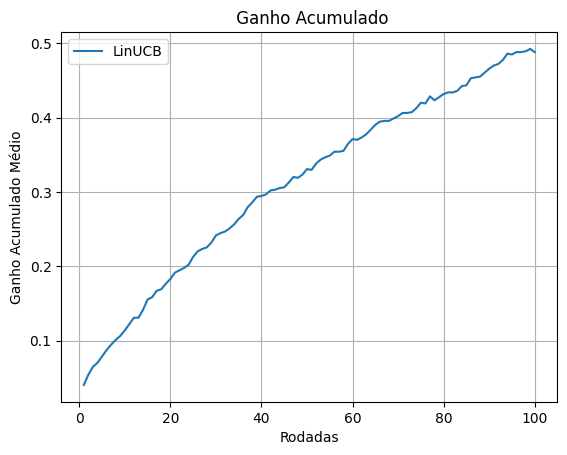

In [22]:
# Plot do ganho acumulado para ambos os algoritmos
plt.plot(range(1, n_rounds_per_user + 1), cumulative_rewards_linucb, label='LinUCB')
plt.title(' Ganho Acumulado')
plt.xlabel('Rodadas')
plt.ylabel('Ganho Acumulado Médio')
plt.legend()
plt.grid(True)
plt.show()

Comparando com o exemplo visto nos exemplos da aula 13, parece que o ganho acumulado final é melhor utilizando features de usuario do que utilizando um kmeans com 5 vizinhos. Pode-se investigar posteriormente o número ótimo de vizinhos e verificar se a compração vence o baseline.